In [1]:
# Cell 1: imports & plotting setup

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Basic plotting style (NMI-like: clean, no top/right spines)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["font.size"] = 9
plt.rcParams["legend.frameon"] = False

tables_dir = os.path.join("..", "results", "tables")
csv_path = os.path.join(tables_dir, "exp11_shape_texture_pier.csv")
df = pd.read_csv(csv_path)

df.head()

,ContextType,ContextLabel,TargetModel,Group,Dose,MeanPIER,StdPIER,NumEvalPoints,NumFitPoints,ContextRawSize
0,dataset,texture_natural,ResNet50,Standard CNN,0.0,0.000274,0.000197,400,400,800
1,dataset,texture_natural,EfficientNetB0,Standard CNN,0.0,0.000076,0.000192,400,400,800
2,dataset,texture_natural,ConvNeXtTiny,Standard CNN,0.0,0.000083,0.000086,400,400,800
3,dataset,texture_natural,ViT_B16,Standard CNN,0.0,0.000057,0.000092,400,400,800
4,dataset,texture_natural,ShapeResNet50_SIN,Shape-biased CNN,0.0,0.000088,0.000240,400,400,800


In [2]:
# Cell 2: small helper to enforce a consistent model order and colors

model_order = [
    "ResNet50",
    "EfficientNetB0",
    "ConvNeXtTiny",
    "ViT_B16",
    "ShapeResNet50_SIN",          # variant A: SIN only
    "ShapeResNet50_SININ",        # variant B: SIN + IN
    "ShapeResNet50_ShapeResNet",  # variant C: SIN+IN then finetuned on IN
]

color_map = {
    "ResNet50": "tab:orange",
    "EfficientNetB0": "tab:green",
    "ConvNeXtTiny": "tab:red",
    "ViT_B16": "tab:purple",
    "ShapeResNet50_SIN": "tab:blue",
    "ShapeResNet50_SININ": "tab:brown",
    "ShapeResNet50_ShapeResNet": "tab:pink",  
}

def order_models(sub_df: pd.DataFrame) -> pd.DataFrame:
    """
    Add a temporary 'Order' column based on `model_order`,
    sort by it, then drop the helper column.

    Models not in `model_order` are pushed to the end (in original order).
    """
    sub = sub_df.copy()
    order_dict = {m: i for i, m in enumerate(model_order)}

    # For models not in model_order, assign a large order number to avoid NaN issues
    sub["Order"] = sub["TargetModel"].map(order_dict).fillna(len(model_order)).astype(int)
    sub = sub.sort_values("Order")
    sub = sub.drop(columns=["Order"])
    return sub


In [3]:
# Cell 3: aggregate mean PIER per context and model

agg = (
    df.groupby(["ContextLabel", "TargetModel"])["MeanPIER"]
    .mean()
    .reset_index()
)

texture_df = order_models(agg[agg["ContextLabel"] == "texture_natural"])
shape_df   = order_models(agg[agg["ContextLabel"] == "shape_bias"])

texture_df, shape_df


(       ContextLabel                TargetModel  MeanPIER
 9   texture_natural                   ResNet50  0.000274
 8   texture_natural             EfficientNetB0  0.000076
 7   texture_natural               ConvNeXtTiny  0.000083
 13  texture_natural                    ViT_B16  0.000057
 10  texture_natural          ShapeResNet50_SIN  0.000088
 11  texture_natural        ShapeResNet50_SININ  0.000089
 12  texture_natural  ShapeResNet50_ShapeResNet  0.000073,
   ContextLabel                TargetModel  MeanPIER
 2   shape_bias                   ResNet50  0.000407
 1   shape_bias             EfficientNetB0  0.000343
 0   shape_bias               ConvNeXtTiny  0.000788
 6   shape_bias                    ViT_B16  0.000297
 3   shape_bias          ShapeResNet50_SIN  0.000432
 4   shape_bias        ShapeResNet50_SININ  0.000316
 5   shape_bias  ShapeResNet50_ShapeResNet  0.000740)

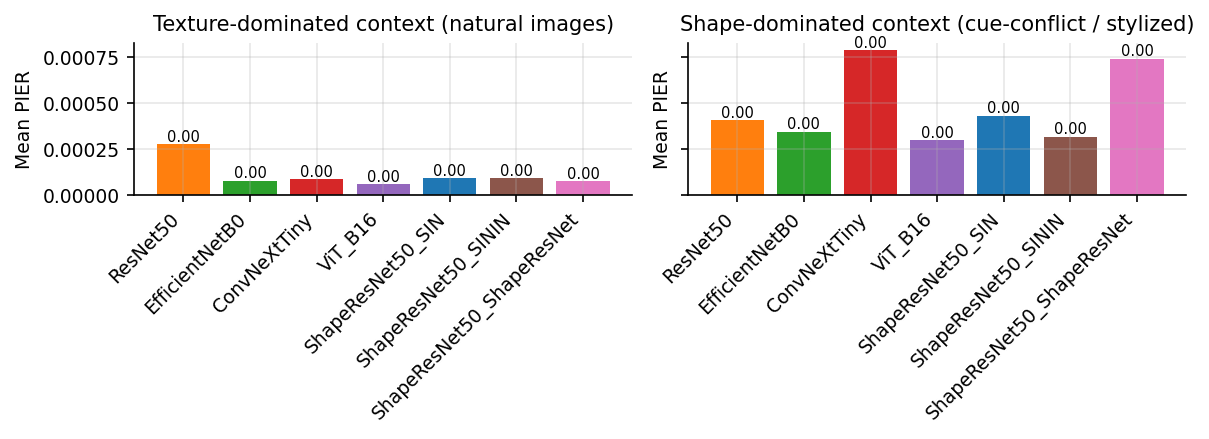

In [4]:
# Cell 4: barplots for texture vs shape contexts (two panels)

fig, axes = plt.subplots(1, 2, figsize=(8, 3.0), sharey=True)

for ax, (sub_df, title) in zip(
    axes,
    [
        (texture_df, "Texture‑dominated context (natural images)"),
        (shape_df,   "Shape‑dominated context (cue‑conflict / stylized)"),
    ],
):
    models = sub_df["TargetModel"].tolist()
    vals = sub_df["MeanPIER"].values
    x = np.arange(len(models))
    colors = [color_map[m] for m in models]

    ax.bar(x, vals, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha="right")
    ax.set_ylabel("Mean PIER")
    ax.set_title(title, fontsize=10)

    for xi, v in zip(x, vals):
        ax.text(xi, v, f"{v:.2f}", ha="center", va="bottom", fontsize=7)

    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


In [5]:
# Cell 5: delta PIER (shape context minus texture context) per model

# Merge the two contexts into a wide table
wide = texture_df[["TargetModel", "MeanPIER"]].rename(
    columns={"MeanPIER": "PIER_Texture"}
).merge(
    shape_df[["TargetModel", "MeanPIER"]].rename(
        columns={"MeanPIER": "PIER_Shape"}
    ),
    on="TargetModel",
    how="inner",
)

wide["Delta_PIER"] = wide["PIER_Shape"] - wide["PIER_Texture"]
wide = order_models(wide)

wide


,TargetModel,PIER_Texture,PIER_Shape,Delta_PIER
0,ResNet50,0.000274,0.000407,0.000132
1,EfficientNetB0,0.000076,0.000343,0.000267
2,ConvNeXtTiny,0.000083,0.000788,0.000704
3,ViT_B16,0.000057,0.000297,0.000240
4,ShapeResNet50_SIN,0.000088,0.000432,0.000343
5,ShapeResNet50_SININ,0.000089,0.000316,0.000227
6,ShapeResNet50_ShapeResNet,0.000073,0.000740,0.000667


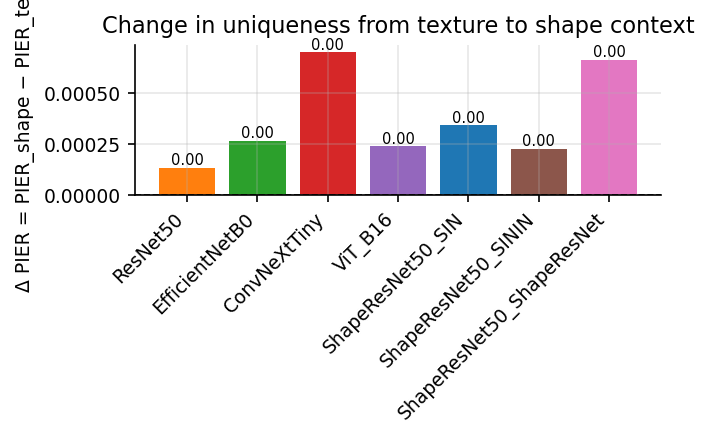

In [6]:
# Cell 6: delta barplot (one panel)

models = wide["TargetModel"].tolist()
vals = wide["Delta_PIER"].values
x = np.arange(len(models))
colors = [color_map[m] for m in models]

plt.figure(figsize=(4.5, 3.0))
plt.bar(x, vals, color=colors)
plt.axhline(0.0, color="black", linewidth=0.8, linestyle="--")

plt.xticks(x, models, rotation=45, ha="right")
plt.ylabel("Δ PIER = PIER_shape − PIER_texture")
plt.title("Change in uniqueness from texture to shape context")

for xi, v in zip(x, vals):
    plt.text(xi, v, f"{v:.2f}", ha="center", va="bottom", fontsize=7)

plt.tight_layout()
plt.show()


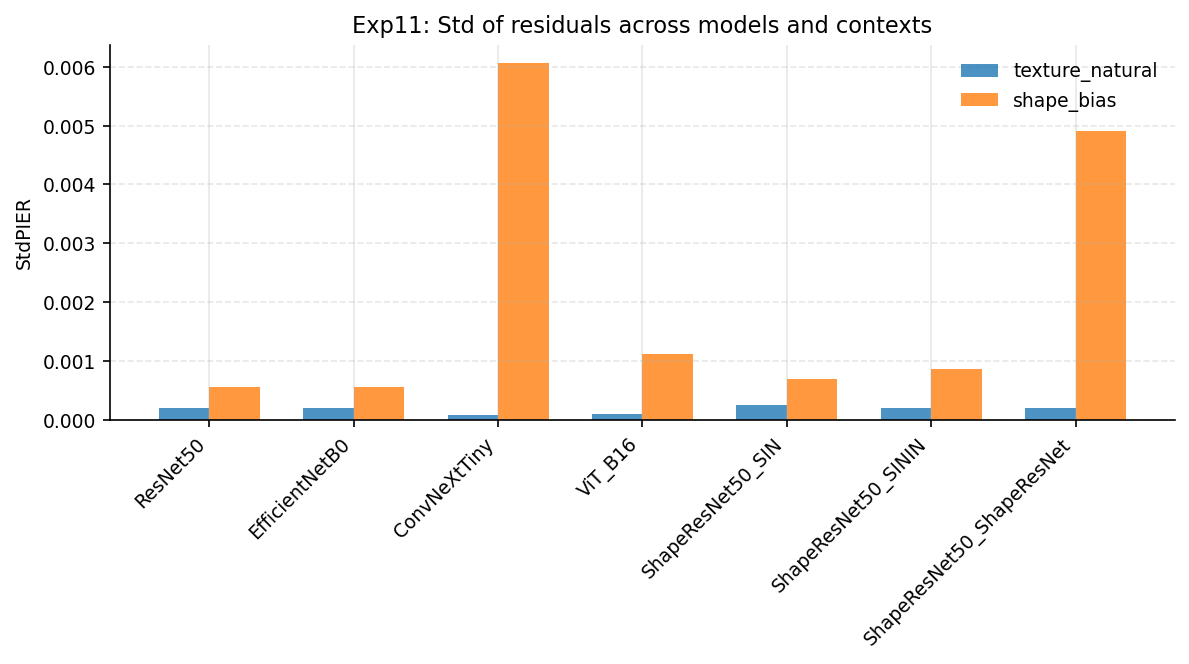

In [ ]:
model_order = [
    "ResNet50",
    "EfficientNetB0",
    "ConvNeXtTiny",
    "ViT_B16",
    "ShapeResNet50_SIN",
    "ShapeResNet50_SININ",
    "ShapeResNet50_ShapeResNet",
]

context_order = ["texture_natural", "shape_bias"]

def order_models(sub_df: pd.DataFrame) -> pd.DataFrame:
    sub = sub_df.copy()
    order_dict = {m: i for i, m in enumerate(model_order)}
    sub["__order"] = sub["TargetModel"].map(order_dict).fillna(len(model_order)).astype(int)
    return sub.sort_values("__order").drop(columns=["__order"])

std_pivot = (
    df.groupby(["TargetModel", "ContextLabel"])["StdPIER"]
    .mean()
    .reset_index()
)
std_pivot = order_models(std_pivot)

fig, ax = plt.subplots(figsize=(8, 4.5))

x = range(len(model_order))
width = 0.35

for i, ctx in enumerate(context_order):
    sub = std_pivot[std_pivot["ContextLabel"] == ctx].set_index("TargetModel").reindex(model_order)
    heights = sub["StdPIER"].values
    ax.bar(
        [xx + (i - 0.5) * width for xx in x],
        heights,
        width=width,
        label=ctx,
        alpha=0.8,
    )

ax.set_xticks(list(x))
ax.set_xticklabels(model_order, rotation=45, ha="right")
ax.set_ylabel("StdPIER")
ax.set_title("Exp11: Std of residuals across models and contexts")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


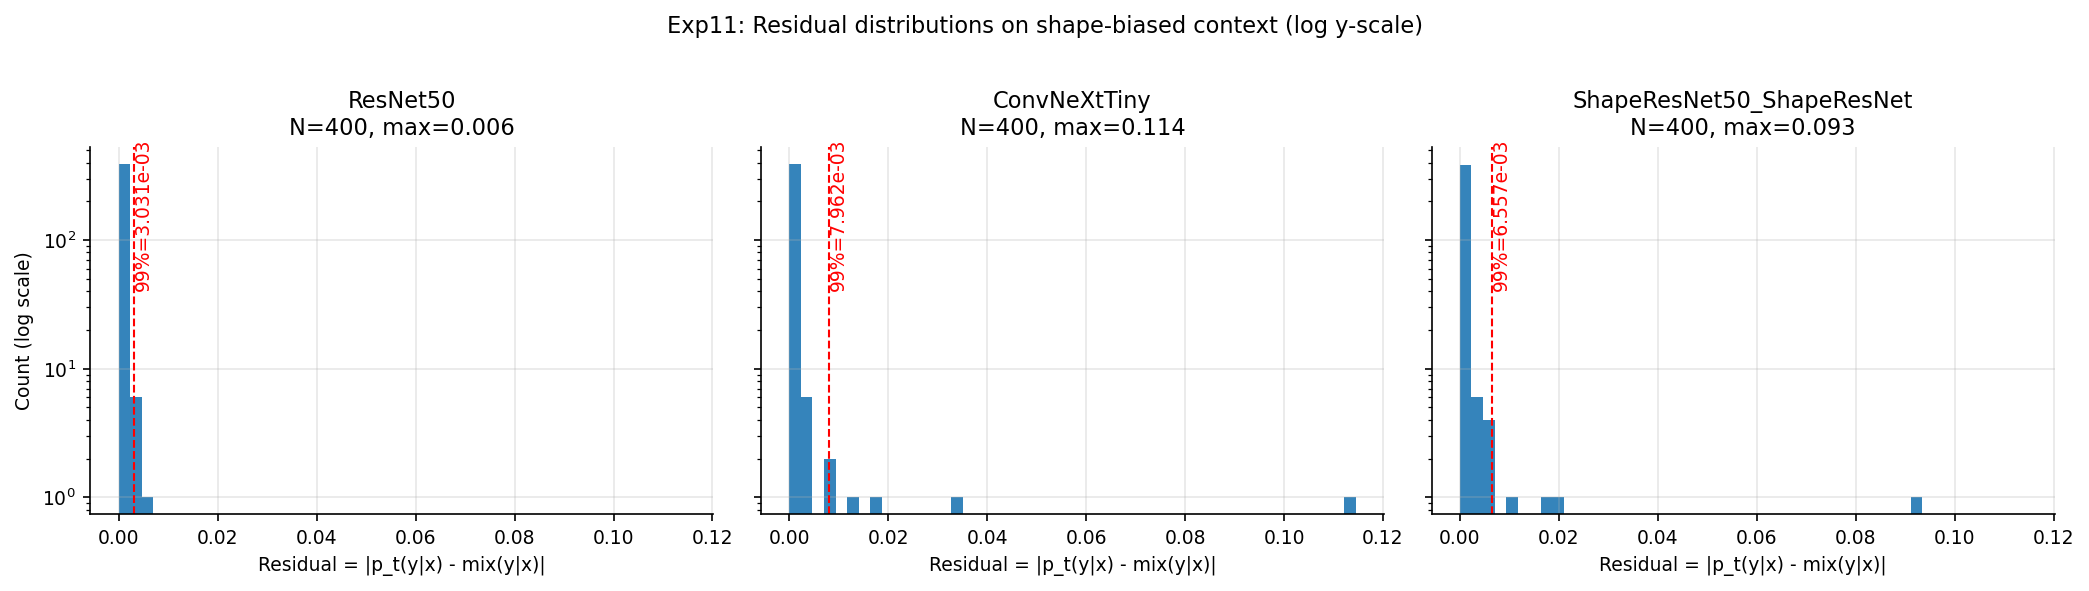

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

res_dir11 = os.path.join("..","results", "artifacts", "exp11")

def load_residuals_exp11(context, model_name):
    path = os.path.join(res_dir11, f"exp11_{context}_{model_name}_residuals.npz")
    data = np.load(path)
    return data["residuals"]

context = "shape_bias"
models_to_plot = [
    "ResNet50",
    "ConvNeXtTiny",
    "ShapeResNet50_ShapeResNet",
]

all_max = []
residuals_dict = {}
for m in models_to_plot:
    r = load_residuals_exp11(context, m)
    residuals_dict[m] = r
    all_max.append(r.max())

global_max = max(all_max)

bins = np.linspace(0.0, global_max, 50)

fig, axes = plt.subplots(1, len(models_to_plot), figsize=(14, 3.8), sharey=True)

for ax, m in zip(axes, models_to_plot):
    r = residuals_dict[m]
    ax.hist(r, bins=bins, log=True, alpha=0.9) 
    ax.set_xlabel("Residual = |p_t(y|x) - mix(y|x)|")
    ax.set_title(f"{m}\nN={len(r)}, max={r.max():.3f}")

    q99 = np.quantile(r, 0.99)
    ax.axvline(q99, color="red", linestyle="--", linewidth=1)
    ax.text(q99, ax.get_ylim()[1]*0.3, f"99%={q99:.3e}", color="red", rotation=90, va="center")

axes[0].set_ylabel("Count (log scale)")
fig.suptitle("Exp11: Residual distributions on shape-biased context (log y-scale)", y=1.02)
plt.tight_layout()
plt.show()


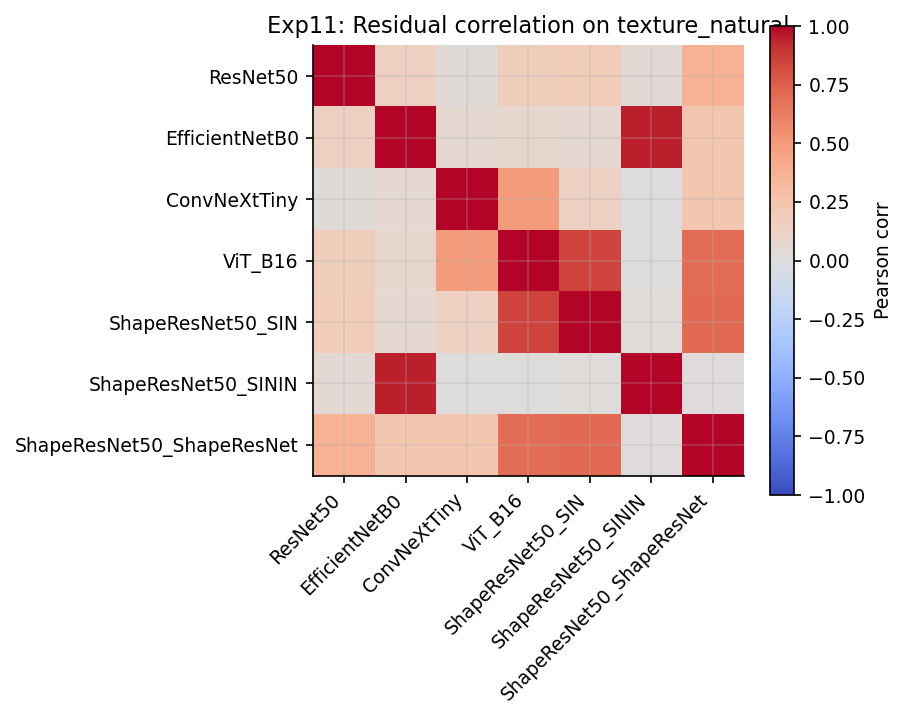

In [ ]:
# Context = natural images
context = "texture_natural"

models_corr = [
    "ResNet50",
    "EfficientNetB0",
    "ConvNeXtTiny",
    "ViT_B16",
    "ShapeResNet50_SIN",
    "ShapeResNet50_SININ",
    "ShapeResNet50_ShapeResNet",
]

residual_matrix = []
for m in models_corr:
    residual_matrix.append(load_residuals_exp11(context, m))
residual_matrix = np.stack(residual_matrix, axis=0)

corr_nat = np.corrcoef(residual_matrix)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr_nat, vmin=-1, vmax=1, cmap="coolwarm")

ax.set_xticks(range(len(models_corr)))
ax.set_xticklabels(models_corr, rotation=45, ha="right")
ax.set_yticks(range(len(models_corr)))
ax.set_yticklabels(models_corr)

ax.set_title(f"Exp11: Residual correlation on {context}")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Pearson corr")

plt.tight_layout()
plt.show()


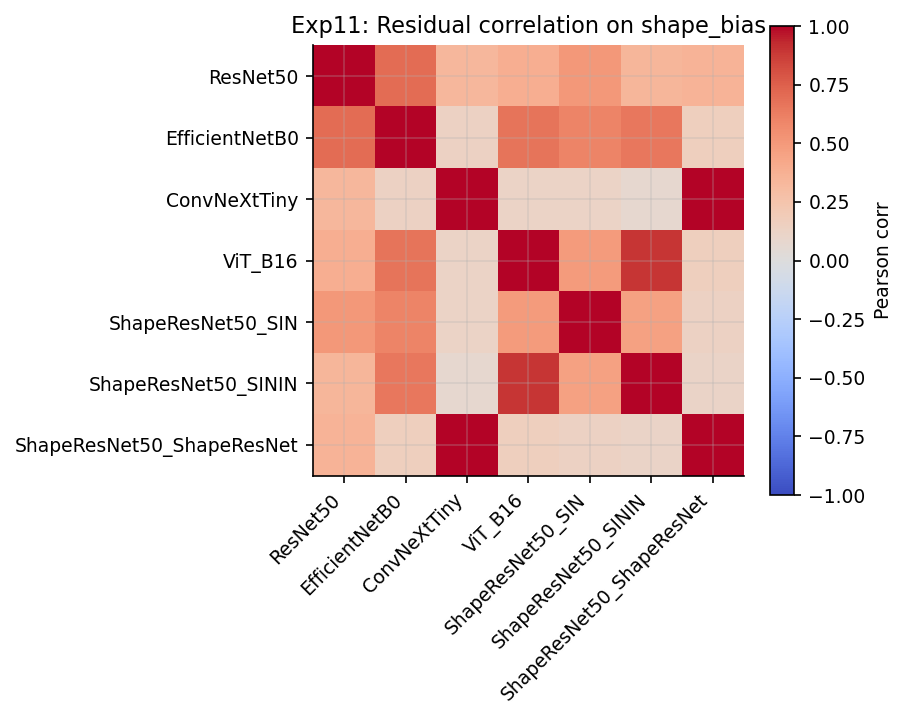

In [10]:
import itertools

def load_residuals_exp11(context, model_name):
    path = os.path.join(res_dir11, f"exp11_{context}_{model_name}_residuals.npz")
    data = np.load(path)
    return data["residuals"]

context = "shape_bias"
models_corr = [
    "ResNet50",
    "EfficientNetB0",
    "ConvNeXtTiny",
    "ViT_B16",
    "ShapeResNet50_SIN",
    "ShapeResNet50_SININ",
    "ShapeResNet50_ShapeResNet",
]

# Construct residual matrix: shape = (num_models, num_eval_points)
residual_matrix = []
for m in models_corr:
    residual_matrix.append(load_residuals_exp11(context, m))
residual_matrix = np.stack(residual_matrix, axis=0)

# Compute Pearson correlation
corr_shape = np.corrcoef(residual_matrix)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr_shape, vmin=-1, vmax=1, cmap="coolwarm")
ax.set_xticks(range(len(models_corr)))
ax.set_xticklabels(models_corr, rotation=45, ha="right")
ax.set_yticks(range(len(models_corr)))
ax.set_yticklabels(models_corr)
ax.set_title(f"Exp11: Residual correlation on {context}")
fig.colorbar(im, ax=ax, label="Pearson corr")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

models_corr = [
    "ResNet50",
    "EfficientNetB0",
    "ConvNeXtTiny",
    "ViT_B16",
    "ShapeResNet50_SIN",
    "ShapeResNet50_SININ",
    "ShapeResNet50_ShapeResNet",
]

idx = {name: i for i, name in enumerate(models_corr)}

def corr_to_2d(corr: np.ndarray) -> np.ndarray:
    """
    把 7x7 的相关矩阵降到二维坐标。
    简单做法：对 corr 做特征分解，取前两个特征向量 * sqrt(特征值)。
    （本质上是 classical MDS / PCA）
    """
    corr = (corr + corr.T) / 2.0
    eigvals, eigvecs = np.linalg.eigh(corr)

    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    coords = eigvecs[:, :2] * np.sqrt(np.maximum(eigvals[:2], 0))
    return coords  # shape: (num_models, 2)

coords_nat = corr_to_2d(corr_nat)
coords_shape = corr_to_2d(corr_shape)


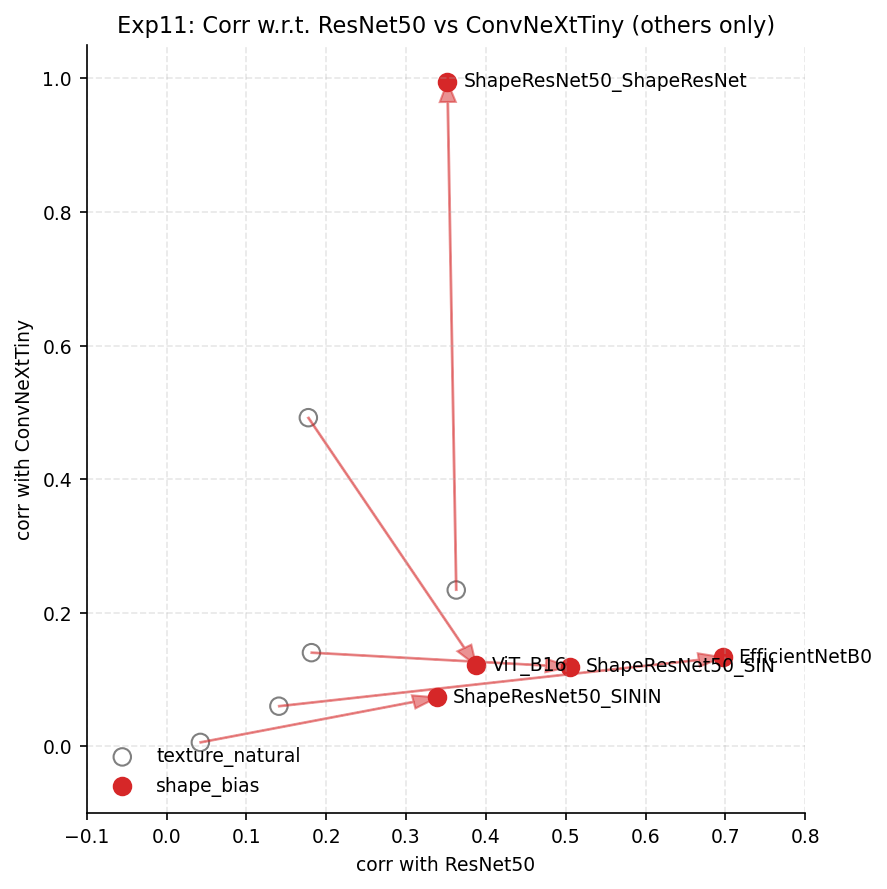

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ref_x = "ResNet50"
ref_y = "ConvNeXtTiny"
ix = idx[ref_x]
iy = idx[ref_y]

models_plot = [m for m in models_corr if m not in (ref_x, ref_y)]

coords_nat = []
coords_shape = []

for m in models_plot:
    j = idx[m]
    coords_nat.append([corr_nat[ix, j], corr_nat[iy, j]])
    coords_shape.append([corr_shape[ix, j], corr_shape[iy, j]])

coords_nat = np.array(coords_nat)
coords_shape = np.array(coords_shape)

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(coords_nat[:, 0], coords_nat[:, 1],
           facecolors="none", edgecolors="gray", s=70, label="texture_natural")

ax.scatter(coords_shape[:, 0], coords_shape[:, 1],
           color="tab:red", s=70, label="shape_bias")

for i, m in enumerate(models_plot):
    x0, y0 = coords_nat[i]
    x1, y1 = coords_shape[i]

    ax.arrow(
        x0, y0,
        x1 - x0,
        y1 - y0,
        length_includes_head=True,
        head_width=0.02,
        head_length=0.03,
        alpha=0.5,
        color="tab:red",
    )

    ax.text(x1 + 0.02, y1, m, fontsize=9, va="center")

ax.set_xlabel(f"corr with {ref_x}")
ax.set_ylabel(f"corr with {ref_y}")
ax.set_title("Exp11: Corr w.r.t. ResNet50 vs ConvNeXtTiny (others only)")
ax.grid(True, linestyle="--", alpha=0.3)
ax.set_xlim(-0.1, 0.8)   
ax.set_ylim(-0.1, 1.05)
ax.legend(loc="lower left")

plt.tight_layout()
plt.show()


Saved: ../results/figures/shape_texture_shift.pdf


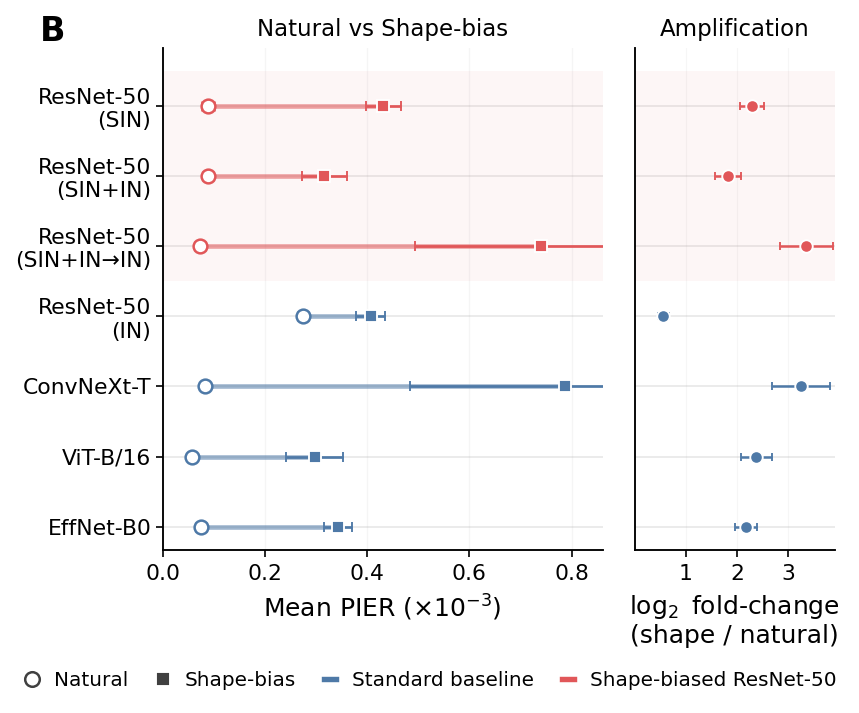

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

FIG_PATH = "../results/figures"
os.makedirs(FIG_PATH, exist_ok=True)

def plot_fig4B_shape_texture(df: pd.DataFrame, save_path: str = None, err_mode: str = "sem"):
    """
    Fig.4B (CV context audit, Exp11):
      Left: dumbbell plot of MeanPIER under two dataset contexts (Natural vs Shape-bias) with error bars.
      Right: context amplification as log2 fold-change: log2(PIER_shape / PIER_natural) with error bars.

    err_mode:
      - "sem": error bars show ±1 s.e.m. of the mean (recommended for clean mean-comparison plots)
      - "ci95": error bars show ±95% CI (1.96 * s.e.m.)

    Notes:
      - We avoid pivot-table MultiIndex issues by splitting and merging two context tables.
      - We rescale PIER by 1e3 for readability (values are ~1e-4).
      - We keep the original Group values for coloring, but rename the legend label
        to avoid calling ViT a CNN.
    """

    # -------------------------
    # Validate inputs
    # -------------------------
    req = {"ContextLabel", "TargetModel", "Group", "Dose", "MeanPIER", "StdPIER", "NumEvalPoints"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns {missing}. Found: {list(df.columns)}")

    if err_mode not in {"sem", "ci95"}:
        raise ValueError(f"err_mode must be 'sem' or 'ci95'. Got: {err_mode}")

    dff = df.copy()
    dff["Dose"] = dff["Dose"].astype(float)
    dff = dff[np.isclose(dff["Dose"], 0.0)].copy()

    # Two contexts in this experiment
    NAT = "texture_natural"
    SHP = "shape_bias"
    dff = dff[dff["ContextLabel"].isin([NAT, SHP])].copy()

    # Compact model names
    NAME_MAP = {
        "ResNet50": "ResNet-50\n(IN)",
        "EfficientNetB0": "EffNet-B0",
        "ConvNeXtTiny": "ConvNeXt-T",
        "ViT_B16": "ViT-B/16",
        "ShapeResNet50_SIN": "ResNet-50\n(SIN)",
        "ShapeResNet50_SININ": "ResNet-50\n(SIN+IN)",
        "ShapeResNet50_ShapeResNet": "ResNet-50\n(SIN+IN→IN)",
    }
    dff["ModelPretty"] = dff["TargetModel"].map(NAME_MAP).fillna(dff["TargetModel"])
    dff["Group"] = dff["Group"].astype(str).str.strip()

    # -------------------------
    # Use SEM (or CI95) for mean uncertainty (not STD variability)
    # -------------------------
    n = dff["NumEvalPoints"].astype(float).clip(lower=1.0)
    dff["SEM"] = dff["StdPIER"].astype(float) / np.sqrt(n)  # s.e.m. of the mean
    mult = 1.96 if err_mode == "ci95" else 1.0
    dff["ERR"] = mult * dff["SEM"]

    # -------------------------
    # Split into two tables and merge (merge on TargetModel to allow custom ordering)
    # -------------------------
    nat = dff[dff["ContextLabel"] == NAT].copy()
    shp = dff[dff["ContextLabel"] == SHP].copy()

    nat = nat[["TargetModel", "ModelPretty", "Group", "MeanPIER", "ERR"]].rename(
        columns={"MeanPIER": "pier_nat", "ERR": "err_nat"}
    )
    shp = shp[["TargetModel", "ModelPretty", "Group", "MeanPIER", "ERR"]].rename(
        columns={"MeanPIER": "pier_shp", "ERR": "err_shp"}
    )

    wide = pd.merge(nat, shp, on=["TargetModel", "Group"], how="inner", suffixes=("_nat", "_shp"))

    if wide.empty:
        raise ValueError("After merging contexts, no rows remain. Check ContextLabel values.")

    # Use a single pretty name column (they should match)
    wide["ModelPretty"] = wide["ModelPretty_nat"]

    # -------------------------
    # Compute effect sizes
    # -------------------------
    SCALE = 1e3  # readability scale for MeanPIER
    wide["pier_nat_s"] = wide["pier_nat"] * SCALE
    wide["pier_shp_s"] = wide["pier_shp"] * SCALE
    wide["err_nat_s"]  = wide["err_nat"] * SCALE
    wide["err_shp_s"]  = wide["err_shp"] * SCALE

    # Log2 fold change
    eps = 1e-15
    wide["log2_fc"] = np.log2((wide["pier_shp"] + eps) / (wide["pier_nat"] + eps))

    # Error of log2 fold-change via delta method
    # If err_mode="sem", err_nat/err_shp are SEM; if "ci95", they are CI => divide back by 1.96
    sem_nat = wide["err_nat"] / (1.96 if err_mode == "ci95" else 1.0)
    sem_shp = wide["err_shp"] / (1.96 if err_mode == "ci95" else 1.0)
    ln2 = np.log(2.0)
    se_log2 = np.sqrt((sem_shp / (wide["pier_shp"] + eps))**2 + (sem_nat / (wide["pier_nat"] + eps))**2) / ln2
    wide["err_log2_fc"] = (1.96 if err_mode == "ci95" else 1.0) * se_log2

    # -------------------------
    # Row ordering: keep the ResNet-50 lineage block together for interpretability
    # -------------------------
    lineage_rank = {
        "ShapeResNet50_SIN": 0,
        "ShapeResNet50_SININ": 1,
        "ShapeResNet50_ShapeResNet": 2,
        "ResNet50": 3,  # IN baseline placed next to the shape variants
    }
    wide["rank"] = wide["TargetModel"].map(lineage_rank).fillna(10).astype(int)
    # Within the "others" block, sort by amplification (desc) to show the strongest context effects
    wide = wide.sort_values(["rank", "log2_fc"], ascending=[True, False]).reset_index(drop=True)

    # -------------------------
    # Style (Nature-like muted palette)
    # -------------------------
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 12,
        "axes.labelsize": 12,
        "xtick.labelsize": 10.5,
        "ytick.labelsize": 10.5,
        "axes.linewidth": 0.9,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

    GROUP_COLORS = {
        "Standard CNN": "#4E79A7",      # muted blue (standard baseline models, includes ViT)
        "Shape-biased CNN": "#E15759",  # muted red  (shape-biased ResNet lineage)
    }

    # Legend labels (avoid calling ViT a CNN)
    GROUP_LABEL = {
        "Standard CNN": "Standard baseline",
        "Shape-biased CNN": "Shape-biased ResNet-50",
    }

    # -------------------------
    # Figure layout
    # -------------------------
    fig = plt.figure(figsize=(5.6, 4.4))
    gs = GridSpec(1, 2, width_ratios=[3.3, 1.5], wspace=0.10)
    ax  = fig.add_subplot(gs[0, 0])
    axr = fig.add_subplot(gs[0, 1], sharey=ax)

    y = np.arange(len(wide))

    # Subtle block shading for the shape-biased lineage (first 3 rows if present)
    k = int((wide["Group"] == "Shape-biased CNN").sum())
    if k > 0:
        ax.axhspan(-0.5, k - 0.5, color=GROUP_COLORS["Shape-biased CNN"], alpha=0.05, lw=0)
        axr.axhspan(-0.5, k - 0.5, color=GROUP_COLORS["Shape-biased CNN"], alpha=0.05, lw=0)

    ax.grid(True, axis="x", linewidth=0.6, alpha=0.12)
    ax.set_axisbelow(True)
    axr.grid(True, axis="x", linewidth=0.6, alpha=0.10)
    axr.set_axisbelow(True)

    # -------------------------
    # Draw rows
    # -------------------------
    for i in range(len(wide)):
        g = wide.loc[i, "Group"]
        c = GROUP_COLORS.get(g, "0.25")

        x_nat  = float(wide.loc[i, "pier_nat_s"])
        x_shp  = float(wide.loc[i, "pier_shp_s"])
        e_nat  = float(wide.loc[i, "err_nat_s"])
        e_shp  = float(wide.loc[i, "err_shp_s"])

        # Connector
        ax.plot([x_nat, x_shp], [i, i], color=c, lw=2.2, alpha=0.55, solid_capstyle="round", zorder=1)

        # Natural: hollow circle
        ax.errorbar(
            x_nat, i, xerr=e_nat,
            fmt="o", ms=6.6,
            mfc="white", mec=c, mew=1.2,
            ecolor=c, elinewidth=1.3, capsize=2.2,
            zorder=3
        )

        # Shape-bias: filled square
        ax.errorbar(
            x_shp, i, xerr=e_shp,
            fmt="s", ms=6.2,
            mfc=c, mec="white", mew=0.9,
            ecolor=c, elinewidth=1.3, capsize=2.2,
            zorder=4
        )

        # Right panel: log2 fold-change with matching uncertainty type
        r = float(wide.loc[i, "log2_fc"])
        er = float(wide.loc[i, "err_log2_fc"])
        axr.errorbar(
            r, i, xerr=er,
            fmt="o", ms=6.0,
            mfc=c, mec="white", mew=0.9,
            ecolor=c, elinewidth=1.2, capsize=2.0,
            zorder=3
        )

    # Y labels
    ax.set_yticks(y)
    ax.set_yticklabels(wide["ModelPretty"].tolist())
    ax.invert_yaxis()
    ax.tick_params(axis="y", pad=2)

    # Axis labels
    ax.set_xlabel(r"Mean PIER ($\times 10^{-3}$)")
    ax.set_title("Natural vs Shape-bias", fontsize=11, pad=6)

    axr.set_xlabel(r"$\log_2$ fold-change" + "\n(shape / natural)")
    axr.set_title("Amplification", fontsize=11, pad=6)
    axr.axvline(0.0, color="0.35", lw=0.9, alpha=0.9)
    axr.tick_params(axis="y", left=False, labelleft=False)

    # Tight x-limits
    xmin = float(np.nanmin(np.r_[wide["pier_nat_s"].to_numpy(), wide["pier_shp_s"].to_numpy()]))
    xmax = float(np.nanmax(np.r_[wide["pier_nat_s"].to_numpy(), wide["pier_shp_s"].to_numpy()]))
    pad = 0.10 * (xmax - xmin + 1e-12)
    ax.set_xlim(max(0.0, xmin - pad), xmax + pad)

    rmin = float(np.nanmin(wide["log2_fc"].to_numpy()))
    rmax = float(np.nanmax(wide["log2_fc"].to_numpy()))
    rpad = 0.20 * (rmax - rmin + 1e-12)
    axr.set_xlim(rmin - rpad, rmax + rpad)

    # -------------------------
    # Legend: make it a figure-level legend (cleaner than bbox_to_anchor hacks)
    # -------------------------
    legend_handles = [
        Line2D([0], [0], marker="o", color="none", label="Natural",
               markerfacecolor="white", markeredgecolor="0.25", markeredgewidth=1.2, markersize=7),
        Line2D([0], [0], marker="s", color="none", label="Shape-bias",
               markerfacecolor="0.25", markeredgecolor="white", markeredgewidth=0.9, markersize=7),
        Line2D([0], [0], color=GROUP_COLORS["Standard CNN"], lw=2.6, label=GROUP_LABEL["Standard CNN"]),
        Line2D([0], [0], color=GROUP_COLORS["Shape-biased CNN"], lw=2.6, label=GROUP_LABEL["Shape-biased CNN"]),
    ]
    fig.legend(
        handles=legend_handles,
        frameon=False,
        fontsize=9.6,
        loc="lower center",
        ncol=4,
        bbox_to_anchor=(0.5, -0.08),
        handlelength=0.6,
        columnspacing=1.4
    )

    # Small note about error bar type
    # ax.text(
    #     0.02, 0.02,
    #     "Error bars: ±1 s.e.m." if err_mode == "sem" else "Error bars: 95% CI",
    #     transform=ax.transAxes,
    #     fontsize=10.0, color="0.35",
    #     ha="left", va="bottom"
    # )

    # Panel label
    ax.text(-0.28, 1.0, "B", transform=ax.transAxes, fontsize=16, fontweight="bold", va="bottom")

    # Final layout
    fig.subplots_adjust(left=0.18, right=0.98, top=0.92, bottom=0.16)

    if save_path is not None:
        fig.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")

    plt.show()
    return fig

# Usage:
plot_fig4B_shape_texture(df, save_path=os.path.join(FIG_PATH, "shape_texture_shift.pdf"), err_mode="sem");


Saved: ../results/figures/shared_outliers_row_skinny.pdf


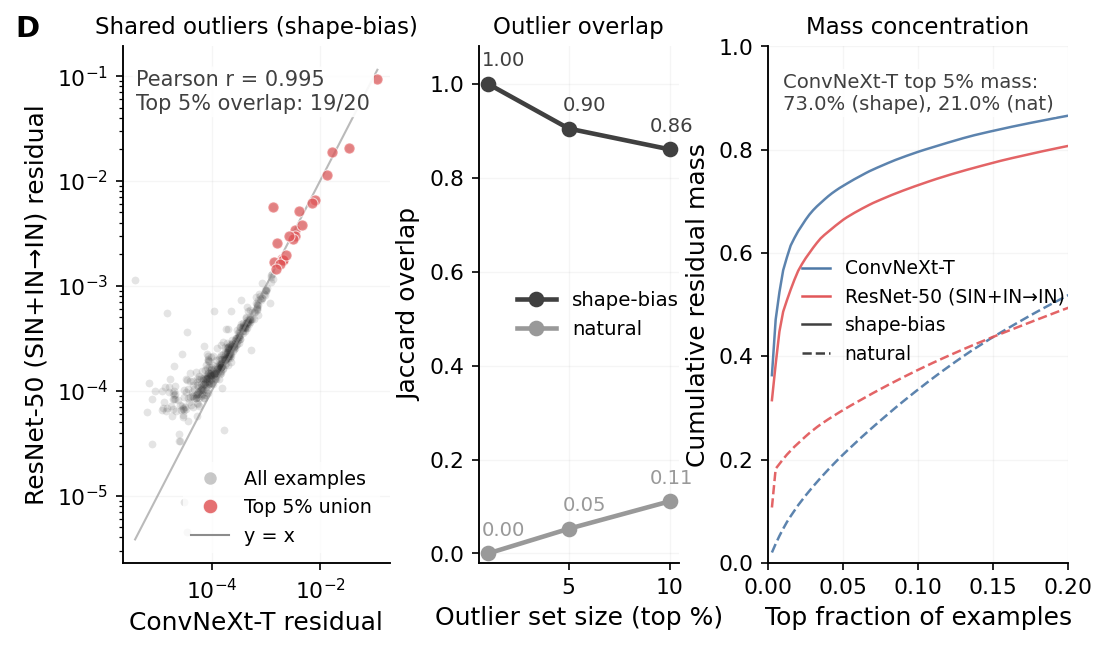

In [14]:
import os
import io
import math
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

FIG_PATH = "../results/figures"
os.makedirs(FIG_PATH, exist_ok=True)

# Point to your artifacts
ARTIFACT_DIR = "../results/artifacts/exp11"
ARTIFACT_ZIP = "../results/artifacts/exp11.zip"   # or "/mnt/data/exp11.zip"

# -------------------------
# Robust loader (dir OR zip)
# -------------------------
def _try_load_npz_from_dir(artifact_dir: str, fname: str):
    fpath = os.path.join(artifact_dir, fname)
    if os.path.exists(fpath):
        return np.load(fpath)
    return None

def _try_load_npz_from_zip(zip_path: str, inner_path: str):
    if not os.path.exists(zip_path):
        return None
    with zipfile.ZipFile(zip_path, "r") as zf:
        if inner_path not in zf.namelist():
            return None
        with zf.open(inner_path) as f:
            return np.load(io.BytesIO(f.read()))

def load_residuals(context: str, model: str, artifact_dir: str = ARTIFACT_DIR, artifact_zip: str = ARTIFACT_ZIP):
    """
    Expected filename:
      exp11_{context}_{model}_residuals.npz
    """
    fname = f"exp11_{context}_{model}_residuals.npz"

    # Try directory
    if artifact_dir is not None and os.path.isdir(artifact_dir):
        data = _try_load_npz_from_dir(artifact_dir, fname)
        if data is not None:
            return data["residuals"].astype(float)

    # Try zip (your zip has inner folder exp11/)
    if artifact_zip is not None and os.path.exists(artifact_zip):
        data = _try_load_npz_from_zip(artifact_zip, f"exp11/{fname}")
        if data is not None:
            return data["residuals"].astype(float)

    raise FileNotFoundError(f"Could not find {fname} in {artifact_dir} or {artifact_zip}.")

# -------------------------
# Stats helpers
# -------------------------
def lorenz_desc(res):
    """Sort residuals descending; return (top-fraction, cumulative mass share)."""
    s = np.sort(np.asarray(res, dtype=float))[::-1]
    n = s.size
    cum = np.cumsum(s)
    x = np.arange(1, n + 1) / n
    y = cum / (cum[-1] + 1e-30)
    return x, y

def topk_indices(res, k):
    res = np.asarray(res, dtype=float)
    return np.argsort(res)[::-1][:k]

def tail_mass_share(res, frac):
    """Share of total residual mass contributed by the top 'frac' examples."""
    res = np.asarray(res, dtype=float)
    n = res.size
    k = max(1, int(math.ceil(frac * n)))
    s = np.sort(res)[::-1]
    return k, float(s[:k].sum() / (s.sum() + 1e-30))

def jaccard_topfrac(res1, res2, frac):
    """Jaccard overlap between top-frac outlier sets."""
    n = len(res1)
    k = max(1, int(math.ceil(frac * n)))
    a = set(topk_indices(res1, k))
    b = set(topk_indices(res2, k))
    inter = len(a & b)
    union = len(a | b)
    return k, inter, float(inter / (union + 1e-30))

# -------------------------
# Fig.4D: 1×3 skinny-tall panels
# -------------------------
def plot_fig4D_row_skinny(save_path: str = None):
    """
    Fig.4D (1×3 layout, skinny & tall panels):
      D1: Shared outliers scatter (shape-bias) with correlation + top-k overlap
      D2: Outlier overlap (Jaccard) vs outlier set size (top %), shape vs natural
      D3: Residual mass concentration (Lorenz-like), showing heavy-tail dominance

    Design goal:
      - High information density without text overlapping plots.
      - All quantitative summaries are placed above axes (clip_on=False) or in empty corners.
    """

    # Models for the phenomenon
    MODEL_A = "ConvNeXtTiny"                # ConvNeXt-T
    MODEL_B = "ShapeResNet50_ShapeResNet"   # ResNet-50 (SIN+IN→IN)
    CTX_SHAPE = "shape_bias"
    CTX_NAT   = "texture_natural"

    # Load residual vectors (same eval set size)
    a_shape = load_residuals(CTX_SHAPE, MODEL_A)
    a_nat   = load_residuals(CTX_NAT,   MODEL_A)
    b_shape = load_residuals(CTX_SHAPE, MODEL_B)
    b_nat   = load_residuals(CTX_NAT,   MODEL_B)

    # Muted Nature-like colors
    C_BLUE = "#4E79A7"
    C_RED  = "#E15759"

    # Style
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 12,
        "axes.labelsize": 12,
        "xtick.labelsize": 10.5,
        "ytick.labelsize": 10.5,
        "axes.linewidth": 0.9,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

    # "Skinny & tall": relatively small width per panel, generous height
    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(7.2, 4.2), 
        gridspec_kw={"width_ratios": [0.8, 0.6, 0.9], "wspace": 0.35}
    )

    for ax in (ax1, ax2, ax3):
        ax.grid(True, which="major", linewidth=0.6, alpha=0.12)
        ax.set_axisbelow(True)

    # -------------------------
    # D1: Shared outliers scatter (shape-bias)
    # -------------------------
    x = a_shape
    y = b_shape

    ax1.scatter(x, y, s=14, color="0.15", alpha=0.12, linewidths=0, zorder=1)

    # Highlight union of top-5% outliers (enough points to be visible)
    k = int(math.ceil(0.05 * len(x)))
    idx = set(topk_indices(x, k)) | set(topk_indices(y, k))
    idx = np.array(sorted(idx), dtype=int)
    ax1.scatter(x[idx], y[idx], s=28, color=C_RED, alpha=0.70,
                edgecolor="white", linewidth=0.5, zorder=3)

    lo = min(x.min(), y.min())
    hi = max(x.max(), y.max())
    ax1.plot([lo, hi], [lo, hi], color="0.55", linewidth=1.0, alpha=0.6)

    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlabel("ConvNeXt-T residual")
    ax1.set_ylabel("ResNet-50 (SIN+IN→IN) residual")
    ax1.set_title("Shared outliers (shape-bias)", fontsize=11, pad=6)

    corr_shape = float(np.corrcoef(a_shape, b_shape)[0, 1])
    k5, inter5, jac5 = jaccard_topfrac(a_shape, b_shape, 0.05)

    # Put summary ABOVE the axis (no overlap)
    ax1.text(
        0.05, 0.87,
        f"Pearson r = {corr_shape:.3f}\nTop 5% overlap: {inter5}/{k5}",
        transform=ax1.transAxes,
        fontsize=10.0, color="0.25",
        ha="left", va="bottom",
        bbox=dict(boxstyle="round,pad=0.18", facecolor="white", edgecolor="none", alpha=0.90),
        clip_on=False
    )
    
    handles = [
        Line2D([0],[0], marker="o", color="none", label="All examples",
            markerfacecolor="0.15", markeredgecolor="none", markersize=6, alpha=0.25),
        Line2D([0],[0], marker="o", color="none", label="Top 5% union",
            markerfacecolor="#E15759", markeredgecolor="white", markeredgewidth=0.5, markersize=7, alpha=0.85),
        Line2D([0],[0], color="0.55", lw=1.0, label="y = x"),
    ]

    ax1.legend(
        handles=handles,
        frameon=True,
        facecolor="white",
        edgecolor="none",
        framealpha=0.75,
        fontsize=9.2,
        loc="lower right"
    )


    # -------------------------
    # D2: Outlier overlap curve (shape vs natural)
    # -------------------------
    fracs = np.array([0.01, 0.05, 0.10])
    jac_shape = [jaccard_topfrac(a_shape, b_shape, f)[2] for f in fracs]
    jac_nat   = [jaccard_topfrac(a_nat,   b_nat,   f)[2] for f in fracs]

    ax2.plot(fracs * 100, jac_shape, marker="o", ms=6.5, lw=2.2, color="0.25", label="shape-bias")
    ax2.plot(fracs * 100, jac_nat,   marker="o", ms=6.5, lw=2.2, color="0.60", label="natural")

    ax2.set_xlabel("Outlier set size (top %)")
    ax2.set_ylabel("Jaccard overlap")
    ax2.set_ylim(-0.02, 1.08)
    ax2.set_title("Outlier overlap", fontsize=11, pad=6)

    # shape-bias labels
    xs = fracs * 100
    for i, (xp, val) in enumerate(zip(xs, jac_shape)):
        dx = -1.0 if i == len(xs) - 1 else -0.3
        ax2.text(xp + dx, val + 0.05, f"{val:.2f}", fontsize=9.4, color="0.25", va="center")

    # natural labels
    for i, (xp, val) in enumerate(zip(xs, jac_nat)):
        dx = -1.0 if i == len(xs) - 1 else -0.3
        ax2.text(xp + dx, val + 0.05, f"{val:.2f}", fontsize=9.4, color="0.60", va="center")


    ax2.legend(frameon=False, fontsize=9.5, loc="lower left",bbox_to_anchor=(0.1, 0.4))

    # -------------------------
    # D3: Residual mass concentration (Lorenz-like)
    # -------------------------
    for res, color, ls, label in [
        (a_shape, C_BLUE, "-",  "ConvNeXt-T (shape)"),
        (a_nat,   C_BLUE, "--", "ConvNeXt-T (nat)"),
        (b_shape, C_RED,  "-",  "ResNet-50 (SIN+IN→IN) (shape)"),
        (b_nat,   C_RED,  "--", "ResNet-50 (SIN+IN→IN) (nat)"),
    ]:
        xx, yy = lorenz_desc(res)
        ax3.plot(xx, yy, color=color, linestyle=ls, linewidth=1.2, alpha=0.92, label=label)

    ax3.set_xlim(0, 0.20)  # focus on top-20% where the story is
    ax3.set_ylim(0.0, 1.0)
    ax3.set_xlabel("Top fraction of examples")
    ax3.set_ylabel("Cumulative residual mass")
    ax3.set_title("Mass concentration", fontsize=11, pad=6)

    # Quantitative summary ABOVE the axis
    _, sh1  = tail_mass_share(a_shape, 0.01)
    _, sh1n = tail_mass_share(a_nat,   0.01)
    _, sh5  = tail_mass_share(a_shape, 0.05)
    _, sh5n = tail_mass_share(a_nat,   0.05)

    ax3.text(
        0.05, 0.87,
        f"ConvNeXt-T top 5% mass:\n{100*sh5:.1f}% (shape), {100*sh5n:.1f}% (nat)",
        transform=ax3.transAxes,
        fontsize=9.4, color="0.25",
        ha="left", va="bottom",
        bbox=dict(boxstyle="round,pad=0.18", facecolor="white", edgecolor="none", alpha=0.90),
        clip_on=False
    )

    # -------------------------
    # Figure-level legend (clean, no per-axes legends except overlap panel)
    # -------------------------
    fig.legend(
        handles=[
            Line2D([0],[0], color=C_BLUE, lw=1.2, label="ConvNeXt-T"),
            Line2D([0],[0], color=C_RED,  lw=1.2, label="ResNet-50 (SIN+IN→IN)"),
            Line2D([0],[0], color="0.25", lw=1.2, label="shape-bias"),
            Line2D([0],[0], color="0.25", lw=1.2, linestyle="--", label="natural"),
        ],
        frameon=False, ncol=1, fontsize=9,
        loc="lower center", bbox_to_anchor=(0.85, 0.41),
        columnspacing=1.6, handlelength=1.5
    )

    # Panel label
    fig.text(0, 0.99, "D", fontsize=14, fontweight="bold", va="top")

    # Final layout padding
    fig.subplots_adjust(left=0.10, right=0.975, top=0.94, bottom=0.12)

    if save_path is not None:
        fig.savefig(save_path)
        print(f"Saved: {save_path}")

    plt.show()
    return fig

# Run
plot_fig4D_row_skinny(save_path=os.path.join(FIG_PATH, "shared_outliers_row_skinny.pdf"));
